In [1]:
from math import sqrt

import numpy as np
import matplotlib.pyplot as plt

import quadpy

In [2]:
from nanoscale_test import fieldplot2

In [3]:
import scattnlay
from scattnlay import fieldnlay
from scattnlay import scattnlay

In [6]:
from math import acos

In [9]:
acos(0)

1.5707963267948966

In [10]:
WL=455 #nm 				# wave length
core_r = 90.0			# partical radius

x = np.ones((1), dtype = np.float64)
x[0] = core_r

npts = 151					# plot will be npts x npts
factor=1.1					# area of plot

index = 4.6265+0.13845j	# refractive index
nm = 1.0						# refractive index of host media

m = np.ones((1), dtype = np.complex128)
m[0] = index/nm

In [12]:
scan = np.linspace(-factor*x[-1], factor*x[-1], npts)
zero = np.zeros(npts*npts, dtype = np.float64)

coordX, coordZ = np.meshgrid(scan, scan)
coordX.resize(npts * npts)
coordZ.resize(npts * npts)
coordY = zero

normalize_units = np.vectorize(lambda t: t/WL*2.0*np.pi)

coord = np.vstack((coordX, coordY, coordZ)).transpose()
_, E, _ = fieldnlay(np.array([normalize_units(x)]), np.array([m]), normalize_units(coord), pl=-1)
Ec = E[0, :, :]
#Hc = H[0, :, :]
#P = np.array(map(lambda n: np.linalg.norm(np.cross(Ec[n], Hc[n])).real, range(0, len(E[0]))))

CPU times: user 165 ms, sys: 169 ms, total: 334 ms
Wall time: 413 ms


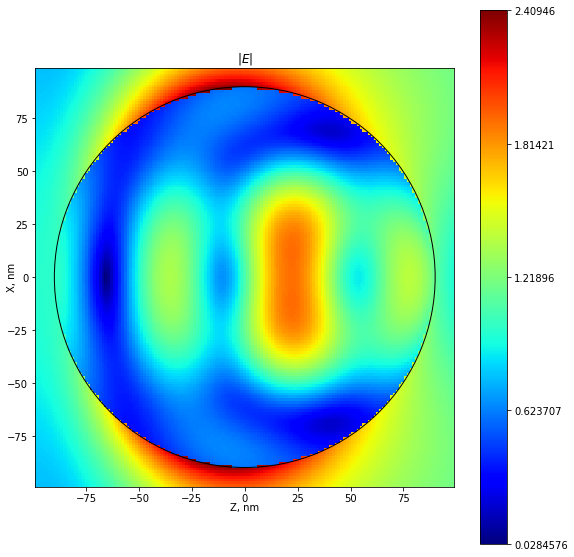

In [13]:
%%time

flow_total = 0

Er = np.absolute(Ec)
Eabs = np.sqrt(Er[:, 0]**2 + Er[:, 1]**2 + Er[:, 2]**2)

fieldplot2(flow_total, Eabs, coordX, coordZ, x, m, npts, factor)

In [14]:
def evaluate(az, normalized_r, normalized_x):
    #print "az", az
    #print "n_r", normalized_r
    #print "n_x", normalized_x.shape
    
    def evaluate_on_sphere(xs):
        #print "xs", xs.shape
        vbx, vby, vbz = xs[0], xs[1], -xs[2]

        bx = vbx / normalized_r * az
        by = vby / normalized_r * az
        bz = vbz / normalized_r * az

        _, E, _ = fieldnlay(np.array([normalized_x]), np.array([m]), np.array([bx, by, bz]).reshape(1, 3), pl=-1)

        assert E.shape == (1, 1, 3)
        #print "E shape", E.shape
        vx, vy, vz = np.real(E[0][0])

        px = by * vz - bz * vy
        py = - bx * vz + bz * vx
        pz = bx * vy - by * vx

        return sqrt((px * px + py * py + pz * pz) / (bx * bx + by * by + bz * bz))

    val = quadpy.sphere.integrate(
        lambda xs: np.apply_along_axis(evaluate_on_sphere, 0, xs),
        [0.0, 0.0, 0.0], normalized_r,
        quadpy.sphere.Lebedev("19")
        )

    return val

In [64]:
from math import sqrt, cos, sin, acos
import quadpy

def _rotate(m, v):
	return np.array(m).dot(np.array(v))

def rotateAroundX(v, angle):
	return _rotate(
		[[1, 0, 0],
		[0, cos(angle), -sin(angle)],
		[0, sin(angle), cos(angle)]], v)

def rotateAroundY(v, angle):
	return _rotate(
		[[cos(angle), 0, sin(angle)],
		[0, 1, 0],
		[-sin(angle), 0, cos(angle)]], v)

def rotateAroundZ(v, angle):
	return _rotate(
		[[cos(angle), -sin(angle), 0],
		[sin(angle), cos(angle), 0],
		[0, 0, 1]], v)

def angle2D(ax, ay, bx, by):
	return acos((ax * bx + ay * by) / sqrt(ax * ax + ay * ay) / sqrt(bx * bx + by * by))

def directiveGain(ax, ay, az, normalized_r, normalized_x):
	def evaluate_on_sphere(vr):
		# TODO: divide by smth
        
		if vr[0] != 0:
			pol = np.array([vr[2] / vr[0], 0, 1])
		elif vr[2] != 0:
			pol = np.array([vr[0] / vr[2], 0, 1])
		else:
			pol = np.array([-1, 0, 0])
		b = np.array([0, 0, 1])

		print "before", vr
        
		angle = angle2D(vr[0], vr[2], 0, 1)
		vr = rotateAroundY(vr, angle)
		pol = rotateAroundY(pol, angle)
		b = rotateAroundY(b, angle)

		angle = angle2D(vr[1], vr[2], 0, 1)
		vr = rotateAroundX(vr, angle)
		pol = rotateAroundX(pol, angle)
		b = rotateAroundX(b, angle)

		angle = angle2D(pol[0], pol[1], 1, 0)
		vr = rotateAroundZ(vr, angle)
		pol = rotateAroundZ(pol, angle)
		b = rotateAroundZ(b, angle)
        
		print "after", vr

		_, E, H = fieldnlay(np.array([normalized_x]), np.array([m]), b.reshape(1, 3), pl=-1)

		assert E.shape == (1, 1, 3)
		vx, vy, vz = E[0][0]
		bx, by, bz = b

		px = by * vz - bz * vy
		py = - bx * vz + bz * vx
		pz = bx * vy - by * vx

		#print px, py, pz, bx, by, bz
		#print px * px + py * py + pz * pz, bx * bx + by * by + bz * bz
		return sqrt((px * px + py * py + pz * pz) / (bx * bx + by * by + bz * bz))

	val = quadpy.sphere.integrate(
	    lambda xs: np.apply_along_axis(evaluate_on_sphere, 0, xs),
	    [0.0, 0.0, 0.0], normalized_r,
	    quadpy.sphere.Lebedev("19"))

	return val

In [65]:
normalized_r = normalize_units(core_r).reshape(1)[0]

In [50]:
hm.shape

(3,)

In [66]:
directiveGain(0, 0, 0.4, normalized_r, normalize_units(x))

before [1.24282786 0.         0.        ]
after [7.61012582e-17 1.52202516e-16 1.24282786e+00]
before [-1.24282786  0.          0.        ]
after [-7.61012582e-17  0.00000000e+00  1.24282786e+00]
before [0.         1.24282786 0.        ]
after [nan nan nan]
before [ 0.         -1.24282786  0.        ]
after [nan nan nan]
before [0.         0.         1.24282786]
after [       nan        nan 1.24282786]
before [ 0.          0.         -1.24282786]
after [-1.52202516e-16  0.00000000e+00  1.24282786e+00]


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:71: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


ValueError: math domain error

In [50]:
xs = np.linspace(0.001, max(coordX))
ys = np.vectorize(lambda t: evaluate(normalize_units(t).reshape(1)[0], normalized_r, normalize_units(x)))(xs)

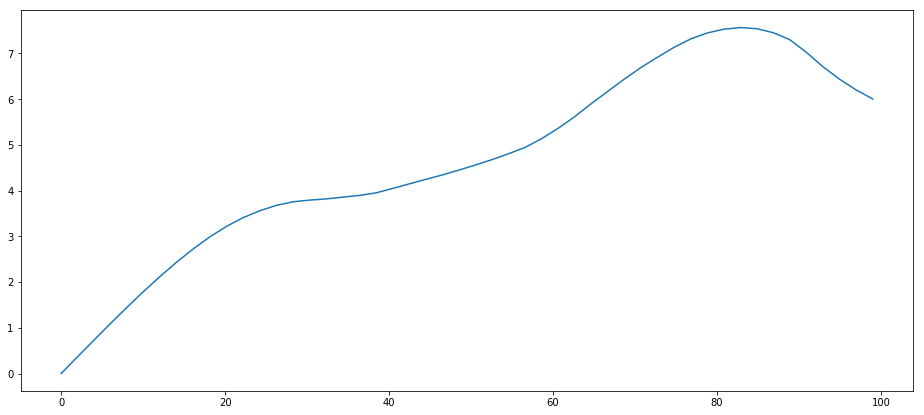

In [51]:
plt.figure(figsize=(16, 7))
_ = plt.plot(xs, ys)